In [ ]:
!jupyter nbconvert seminar.ipynb --to slides --post serve 

In [2]:
import numpy as np
import sys
import os
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display
sys.path.append(os.path.abspath('..'))
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *
%load_ext autoreload

In [3]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv', parse_dates=['Date'])
original_data = raw_data.sort_values(['CountryCode', 'Date']).copy()
first_values = original_data.sort_values(['CountryCode', 'Date'])['CountryCode'].drop_duplicates()
today_values = original_data[original_data['Date'].dt.date == pd.Timestamp.today().date()]
original_data = original_data[['CountryName', 'CountryCode', 'Date', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndexForDisplay']].drop(today_values.index)
original_data.loc[first_values.index] = 0
original_data = original_data.fillna(method='bfill')

py_odes = loadmat('C:/Users/kipr/Documents/GitHub/files/internship/data/py_odes.mat')
cubic_oscillator = py_odes['cubic_oscillator']
t = py_odes['t'][0]


def get_data(country):
    return original_data[original_data['CountryName'] == country].copy()

def get_trajectory(country, rescaling=1000):
    return get_data(country)['ConfirmedCases'].values.reshape(-1, 1)/rescaling


def show_trajectory(country, length=100):
    trajectory = get_trajectory(country)
    guess = integrate(weights, [0.5], 
                      np.arange(0, length), 
                      derivative=derivative)

    guess = np.clip(guess, a_min=-1, a_max=2*max(trajectory))

    plt.figure(dpi=100)
    plt.plot(trajectory, 'k.', label='real')
    plt.plot(guess, label='predicted')
    plt.title(country)
    plt.legend()
    plt.show()



# Data-driven COVID-19 modeling

<center><img src="image.png" width="400"></img></center>


Cyprien Neverov<small><sup>1</sup></small>

May 5<sup>th</sup>, 2020


---
<small>
<sup>1</sup>
Student at IMT Mines Ales and intern at FAU Erlangen-Nurnberg under the supervision of Prof. Zuazua.
</small>

## Table of Contents

1. Introduction and data-driven system identification
2. COVID-19 evolution in different countries
3. Global evolution



## 1. Introduction and data-driven system identification

Identifying the dynamics from data is becoming a key challenge because:
 - Data acquisition is getting cheaper
 - Problems are getting more complex
 - Computational power is cheap




### Sparse identification of nonlinear dynamical systems

Approach proposed by S. Brunton in [1]. 

- Uses sparse regression
- Relies on a set of candidate functions

Expresses the dynamics as a function $f$ which is a linear combination of the candidate functions:

$$\frac{dx}{dt}(t) = f(x(t))$$

where $x$ is the state of the system.

#### 1. Make two matrices 
Let's say that we have observed the system at $t_1, t_2, ..., t_m$ and either observed or numerically computed its time derivative at those time points, then we can construct the two following matrices:

$$\dot{X} = 
\begin{bmatrix}
\frac{dx}{dt}(t_1) \\
\frac{dx}{dt}(t_2) \\
\vdots \\
\frac{dx}{dt}(t_m)
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
x(t_1) \\
x(t_2) \\
\vdots \\
x(t_m)
\end{bmatrix}
$$


#### 2. Augment the state matrix
And then we can augment the $X$ matrix with the candidate functions $f_1, f_2, \dots, f_p$ this will yield $\theta(X)$:
$$\theta(X) = 
\begin{bmatrix}
f_1(x(t_1)) & f_2(x(t_1)) & \cdots & f_p(x(t_1))\\
f_1(x(t_2)) & f_2(x(t_2)) & \cdots & f_p(x(t_2))\\
\vdots & \vdots  & \ddots & \vdots\\
f_1(x(t_m)) & f_2(x(t_m)) & \cdots & f_p(x(t_m))\\
\end{bmatrix}
$$



#### 3. Solve the linear least squares

Now we want to find a matrix $\xi$ that is a solution to:

$$\dot{X} = \theta(X)\xi$$

in the least squares sense. The sparsity is achieved by running the optimization several times and gradually zeroing out the values that are under a cut-off value.

#### Discretized formulation

This algorithm also works in an iterative manner, when instead of $\dot{X}$ we have $X_2$:

$$
X_2 = 
\begin{bmatrix}
x(t_2) \\
x(t_3) \\
\vdots \\
x(t_m)
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
x(t_1) \\
x(t_2) \\
\vdots \\
x(t_{m-1})
\end{bmatrix}
$$

and then we seek to solve $X_2 = \theta(X)\xi$


### Simple example

Oscillator with a cubic nonlinearity:

\begin{align}
    \dot{x} & = -0.1x^3 + 2y^3 \\
    \dot{y} & = -2x^3 -0.1y^3 
\end{align}

From now on we will consider only polynomial terms of the variables as candidate functions: $x, y, x^2, xy, y^2, x^3, \dots, y^p$.


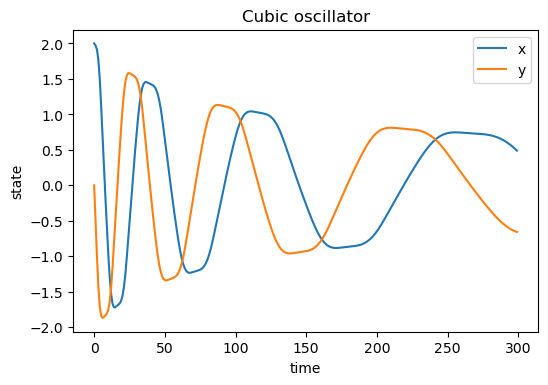

In [3]:
plt.figure(dpi=100)
plt.plot(cubic_oscillator[:, 0], label='x')
plt.plot(cubic_oscillator[:, 1], label='y')
plt.legend()
plt.xlabel('time')
plt.ylabel('state')
plt.title('Cubic oscillator')
plt.show()

In [4]:
X_dot, X = make_targets(cubic_oscillator, derivative=True)

theta_X, _ = make_polynomials(X, max_degree=3)

weights, _ = sparse_regression(theta_X, X_dot, cutoff=1e-3)
weights /= t[1]

show_weights(weights, derivative=True)

| function   |   $\dot{x}$ |   $\dot{y}$ |
|:-----------|------------:|------------:|
| $1$        |     0       |   0         |
| $ x$       |     0       |   0         |
| $ y$       |     0       |   0         |
| $ x^2$     |     0       |   0         |
| $ x y$     |     0       |   0         |
| $ y^2$     |     0       |   0         |
| $ x^3$     |    -0.10289 |  -1.983     |
| $ x^2 y$   |     0       |   0         |
| $ x y^2$   |     0       |   0         |
| $ y^3$     |     1.98221 |  -0.0941117 |

## 2. Applying system identification to COVID-19

The trajectories of cumulative cases:

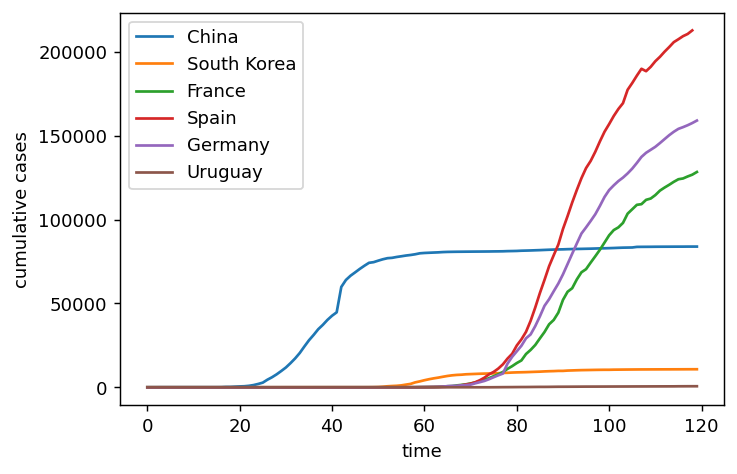

In [5]:
countries_to_display = ['China', 'South Korea', 'France', 'Spain', 'Germany', 'Uruguay']

plt.figure(dpi=130)
for country in countries_to_display:
    values = get_data(country)
    plt.plot(values['ConfirmedCases'].values, label=country)
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative cases')
plt.show()

| function   |    $\dot{x}$ |
|:-----------|-------------:|
| $1$        |  0.00896544  |
| $ x$       |  0.221242    |
| $ x^2$     | -0.00180733  |
| $ x^3$     |  3.79674e-06 |

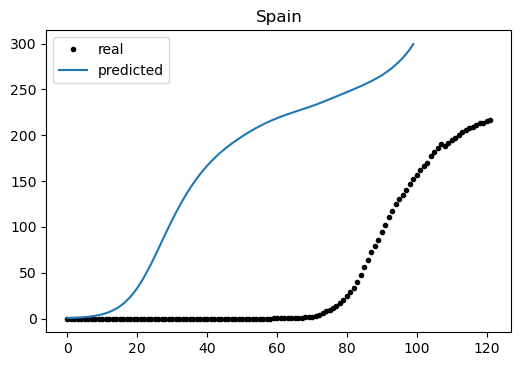

In [129]:
country = 'Spain'
X_dot, X = make_targets(get_trajectory(country, rescaling=1000)[:-1], derivative=(derivative:=True))
theta_X, _ = make_polynomials(X, max_degree=3)
weights, _ = sparse_regression(theta_X, X_dot, cutoff=1e-7)
show_weights(weights, derivative=derivative)
show_trajectory(country)

### Observations

- A single trajectory can be described by only two or three parameters.
- We do not have the complete evolutions for most of the countries.

How can we use the information from countries that are more advanced into the epidemic to make predictions for countries at a more early stage ?

## 3. Global model

What if the evolution of the number of cases in several countries could be governed by a single formula?

This would require additional information:
- Information about the countries
- Information about the measures taken by the governments to tackle the spread of the disease

We would like to find a function $f$ such that for any country $c$, at any day $t$, we have:

$$x_{t+1, c} = f(x_{t, c}, i_{t, c})$$

Where $i$ is this additional information.


### Information about the countries

List of country indicators relevant to the pandemic by the World Bank [2], divided into 3 categories:

- Health: general information about health infrastructure, economics and mortality causes.
- Water & Sanitation: information about hygiene.
- Age & Population: demographic indicators.




### Information about the government measures

Social distancing measures had a huge impact on the development of the disease and we want to take them into account. We use a "Stringency Index" provided by a group of researchers from Oxford [3].
- An aggregation of policy indicators: information on containment and closure policies, such as school closures and restrictions in movement.
- Should not be interpreted as effectiveness of the measures.


#### Examples of Sringency Index

In [41]:
list_countries = list(filter(lambda x: x!= 0, original_data['CountryName'].unique()))


def plot_cases_and_stringency(country):
    country_data = get_data(country)

    fig, ax1 = plt.subplots(dpi=100)

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('Cases')
    ax1.plot(country_data['ConfirmedCases'].values[:-1], 'k.', label='cases')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Stringency', color=color)
    ax2.plot(country_data['StringencyIndexForDisplay'].values[:-1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(country)
    plt.show()
    
widgets.interact(plot_cases_and_stringency, country=list_countries);

interactive(children=(Dropdown(description='country', options=('Aruba', 'Afghanistan', 'Angola', 'Albania', 'A…

### Putting it all together

Here is a description of the information that was used for the model:

| Variable  | Explanation  | Nature  |
|---|---|---|
| $x_t$  | The state of the system: the number of cases in the country  | The state, time-dependent  |
| $i_{1, t}$  |  Stringency index: how severe are the containment measures. (the control) | Time-dependent  |
| $i_{2}$ | Human development index  | Constant  |
| $i_{3}$ | Total population  | Constant  |
| $i_{4}$ | Population ages 65 and above (% of total)  | Constant  |
| $i_{5}$ | Hospital beds (per 1,000 people)  |  Constant |
| ... | ...  | ...  |
| $i_{40}$ | Cause of death, by injury (% of total)  | Constant  |



We want to find a general formula of the following form<small><sup>1</sup></small>:

$$x_{t+1} = f(x_t, i_{1, t}, i_2, i_3, i_4, ... , i_{40})$$ 

-----
<small><sup>1</sup>The country indexes were omitted for better readability.</small>

This what the two matrices will look like for a single country:

$$
X_{2, c} = 
\begin{bmatrix}
x_{t_2, c} \\
x_{t_3, c} \\
\vdots \\
x_{t_n, c} \\
\end{bmatrix}
\text{ and }
X_{1, c} = 
\begin{bmatrix}
x_{t_1, c} & i_{t_1, 1, c} & i_{2, c} & \cdots & i_{40, c} & \\
x_{t_2, c} & i_{t_2, 1, c} & i_{2, c} & \cdots& i_{40, c} & \\
\vdots  & \vdots & \vdots & \ddots & \vdots & \\
x_{t_{n - 1}, c} & i_{t_{n - 1}, 1, c} & i_{2, c} & \cdots & i_{40, c}
\end{bmatrix}
$$

And then we stack them:

$$
X_{2} = 
\begin{bmatrix}
X_{2, c_1} \\
X_{2, c_2} \\
\vdots \\
X_{2, c_m} \\
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
X_{1, c_1} \\
X_{1, c_2} \\
\vdots \\
X_{1, c_m} \\
\end{bmatrix}
$$


### Fitting

Experimental setting:

- 4857 training examples (rows in the $X$ and $X_2$ matrices) and 1028 test examples for 105 and 26 countries respectively. 
- 42 variables (state + stringency + indicators). 
- Polynomial terms with a maximum degree of 3.
- We neglect the terms that are constant with respect to the state.
- This yields more than 800 polynomial terms. 

The number of polynomial terms is equal to $\frac{(n + r - 1)!}{ r! (n - 1)! }$ where $n$ is the number of variables and $r$ the maximum degree.



### Influence of the cutoff value

Choosing a cutoff value is not trivial.

![](../sparsity_vs_mse.png)

### Results on countries from the training set

In [4]:
train_countries = ['United Arab Emirates', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Switzerland', 'China', 'Czech Republic', 'Germany', 'Dominican Republic', 'Ecuador', 'Egypt', 'Spain', 'France', 'United Kingdom', 'Indonesia', 'India', 'Iran', 'Israel', 'Italy', 'Japan', 'South Korea', 'Mexico', 'Malaysia', 'Netherlands', 'Norway', 'Pakistan', 'Peru', 'Philippines', 'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'Singapore', 'Serbia', 'Sweden', 'Turkey', 'Ukraine', 'United States']
test_countries = ['Poland', 'Chile', 'Colombia', 'South Africa', 'Panama', 'Ireland', 'Qatar', 'Denmark', 'Bangladesh']
configs = [('cutoff=1e-4, sparsity=0%', 'plots'), ('cutoff=1, sparsity=98%', 'test_plots')]

def plot(country, config):
    plt.figure(dpi=150)
    img = mpimg.imread(f'../{config}/{country}.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

widgets.interact(plot, country=train_countries, config=configs);

interactive(children=(Dropdown(description='country', options=('United Arab Emirates', 'Australia', 'Austria',…

### Results on test countries

In [5]:
widgets.interact(plot, country=test_countries, config=configs);

interactive(children=(Dropdown(description='country', options=('Poland', 'Chile', 'Colombia', 'South Africa', …

### Other configurations

Other configurations were tried:

- Different state: cumulative number of cases divided by the total population.
- Including different precedent states of both the state and stringency.

But not all possible:

- Number of tests per countries.
- Climatic indicators an others.
- Excluding countries with low numbers and very chaotic trajectories.

### From a Machine Learning perspective

We are trying to do two tasks at the same time:

1. Predict the global parameters of the evolution in a country given the indicators (general regression).
2. Predict the day by day evolution (time-series forecasting).

We should probably use different models.


### From an epidemiological perspective

Standard epidemiological models study the interaction between different compartments of the population:
 - $S$ the number of susceptible people, 
 - $I$ the number of infected, 
 - $R$ the number of recovered people.

They were first introduced in [4].

We might want to use this well-established knowledge.

## Conclusion - Future directions

- Single-country evolutions are learned well.
- With a big amount of variables the model overfits.

We will:

- Try to get closer to SIR-based models
- Try to keep the idea of working with multiple countries at the same time to extract knowledge.



## References


[1] Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz. 2016. “Discovering Governing Equations from Data by Sparse Identification of Nonlinear Dynamical Systems.” <em>Proceedings of the National Academy of Sciences</em> 113 (15): 3932–7. <a href="https://doi.org/10.1073/pnas.1517384113">https://doi.org/10.1073/pnas.1517384113</a>.


[2] Hale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira. 2020. “Oxford COVID-19 Government Response Tracker.” <em>Blavatnik School of Government</em>. <a href="https://github.com/OxCGRT/covid-policy-tracker/">https://github.com/OxCGRT/covid-policy-tracker/</a>.

[3] “Understanding the Coronavirus (COVID-19) Pandemic Through Data. World Bank.” n.d. <a href="http://datatopics.worldbank.org/universal-health-coverage/covid19/">http://datatopics.worldbank.org/universal-health-coverage/covid19/</a>.

[4] Kermack, William Ogilvy, A. G. McKendrick, and Gilbert Thomas Walker. 1997. “A Contribution to the Mathematical Theory of Epidemics.” <em>Proc. R. Soc. Lond.</em> 12: 700–721. <a href="https://doi.org/10.1098/rspa.1927.0118">https://doi.org/10.1098/rspa.1927.0118</a>.

## Appendix

### Indicators

```
Hospital beds (per 1,000 people),
Physicians (per 1,000 people),
Nurses and midwives (per 1,000 people),
UHC service coverage index,
Human development index,
Current health expenditure (% of GDP),
Current health expenditure per capita (current US$),
Current health expenditure per capita, PPP (current international $),
Out-of-pocket expenditure (% of current health expenditure),
Out-of-pocket expenditure per capita (current US$),
Out-of-pocket expenditure per capita, PPP (current international $),
Diabetes prevalence (% of population ages 20 to 79),
Life expectancy at birth, female (years),
Life expectancy at birth, total (years),
Life expectancy at birth, male (years),
Mortality rate, adult, female (per 1,000 female adults),
Mortality rate, adult, male (per 1,000 male adults),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, female (%),
Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%),
Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total),
Cause of death, by injury (% of total),
Cause of death, by non-communicable diseases (% of total),
People using at least basic drinking water services (% of population),
People using at least basic sanitation services (% of population),
Population ages 80 and above, female (% of female population),
Population ages 80 and above, male (% of male population),
Population ages 65 and above, female (% of total),
Population ages 65 and above, male (% of total),
Population ages 65 and above (% of total),
Population ages 0-14, female (% of female population),
Population ages 0-14, male (% of male population),
Population ages 0-14 (% of total population),
Population ages 15-64, female (% of female population),
Population ages 15-64, male (% of male population),
Population ages 15-64 (% of total population),
Total population
```

### Importance of the indicators

Let the importance of a variable be the normalized sum of the absolute value of the coefficients of the polynomial terms where this variable appears.



#### For a cutoff value of $10^{-4}$ and sparsity of $0$%

<img src='importances_train.png' width='700'></img>

<!-- ![](importances_train.png) -->

#### For a cutoff value of $1$ and sparsity of $98$%

![](importances_test.png)

### Logistic trajectories

Most of the trajectories have an evolution close to a logistic function:

$$x(t) = \frac{a}{1+e^{-b(t-c)}}$$

Where $a, b$ and $c$ are the parameters.

Since the derivative of a logistic function is: $\frac{dx}{dt}(t) = x(t)\times (1 - x(t))$ we should be able to have some baseline results with polynomials of a maximum degree of 2.




### Integrating the identified system

We can easily generate a trajectory with $\: x_{k+1} = \theta(x_k)\xi \:$ or using the differential formulation $\: \dot{x} = \theta(x)\xi \:$ and solving the ODE. But synchronizing is difficult.